<a href="https://colab.research.google.com/github/PGM-Lab/2022-ProbAI/blob/main/Day2-Evening/notebooks/students_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adapt the variational auto encoder

Below you will find an implementation of a VAE for the MNIST data. To allow for faster learning time, we only consider the digits 0,1, and 2 and only the first 100 samples of those digits.

In this exercise, you should familiarize yourself with the implementation below and experiment with the structure of the VAE specification in order to emphasize digit separation in the latent space and the generation of images when sampling from the latent space.

Part of the implementation is based on code from the official Pyro examples.

In [89]:
!pip install -q --upgrade pyro-ppl torch

import numpy as np
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import datetime
import os
import matplotlib.gridspec as gridspec
from matplotlib import pyplot
import matplotlib.pyplot as plt
from scipy.stats import norm

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Get the MNIST data


In [90]:
data = datasets.MNIST('./data', train=True, download=True)

# We only select the digits 0, 1, and 2 and only the first 100 of each of these
# digits

selector = np.array([], dtype=int)
for i in [5, 6, 7]:
    selector = np.concatenate((selector, np.where(data.targets == i)[0][:100]))
data.data = data.data[selector, :, :]
data.targets = data.targets[selector]

# Binarize the data
data.data[data.data<128] = 0
data.data[data.data>=128] = 1

data.data = data.data.type(torch.float)
data.data = data.data.reshape(300,-1)

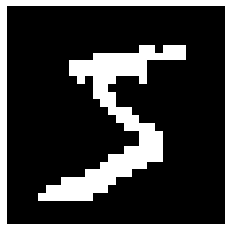

In [91]:
def display_image(x):
    plt.axis('off')
    plt.imshow(x.reshape((28, 28)), cmap="gray")

toy_image = data.data[0,:]
display_image(toy_image)

# Defining a VAE in Pyro

In the following implementation, the econder and decoder networks are provided as a paramter to the VAE.

In [92]:
class VAE(nn.Module):
    def __init__(self, z_dim, encoder, decoder, use_cuda=True):
        super(VAE, self).__init__()
        # set the encoder and decoder networks
        self.encoder = encoder
        self.decoder = decoder
        
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(logits=loc_img).to_event(1), obs=x.reshape(-1, 784))
            #pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

    def sample_image(self, z):
        loc_img = self.decoder.forward(z)
        return dist.Bernoulli(logits=loc_img).sample()


    def sample_images(self, dim=10):

        plt.figure(figsize=(dim, dim))
        gs1 = gridspec.GridSpec(dim, dim)
        gs1.update(wspace=0.025, hspace=0.05)  # set the spacing between axes.

        z_1 = norm.ppf(np.linspace(0.00001, 0.99999, dim), loc=0, scale=1)
        z_2 = norm.ppf(np.linspace(0.00001, 0.99999, dim), loc=0, scale=1)
        for j in range(dim):
            for i in range(dim):
                x_val = self.decoder.forward(torch.tensor([z_1[i], z_2[j]], dtype=torch.float32))
                plt.subplot(gs1[i*dim+j])
                plt.axis('off')
                plt.imshow(x_val.detach().numpy().reshape((28, 28)), cmap="gray_r")
        plt.show()

# Defining the Encoder



In [93]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.non_linearity = nn.ReLU()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.non_linearity(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

# Defining the Decoder

## A Linear Decoder

The following code define a linear decoder (i.e. a linear mapping) between the latent representation $z$ and the output space $x$

In [94]:
class LinearDecoder(nn.Module):
    def __init__(self, z_dim):
        super(LinearDecoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, 784)

    def forward(self, z):
        # define the forward computation on the latent z

        # return the parameter for the output Bernoulli
        logits_img = self.fc1(z)

        return logits_img

## **Exercise 1: Define a Non-Linear Decoder**

1. Define as decoder network a MLP with a hidden layer and a non-linear function (e.g. Relu). 

2. The number of the number of hidden units should be parametrized.

In [102]:
class NonLinearDecoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(NonLinearDecoder, self).__init__()
        
        # Define the first layer
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        
        # Define the second layer
        
        # Define the non-linearities
        self.non_linearity = nn.ReLU()

    def forward(self, z):
        # define the forward computation on the latent z

        # first compute the hidden units
        hidden = self.fc1(z)
        
        # return the parameter for the output Bernoulli
        logits_img = 0 #??? 

        return logits_img

# Training a VAE in Pyro

### Setup training (single epoch)

In [96]:
def train(svi, data):

    epoch_loss = svi.step(data)

    # return epoch loss
    normalizer_train = len(data)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

### Perform learning

[epoch 000] average training loss: 579.4560
[epoch 100] average training loss: 210.5405
[epoch 200] average training loss: 184.1442
[epoch 300] average training loss: 177.3236
[epoch 400] average training loss: 173.5897
[epoch 500] average training loss: 170.9770
[epoch 600] average training loss: 168.5690
[epoch 700] average training loss: 166.9320
[epoch 800] average training loss: 165.6451
[epoch 900] average training loss: 164.4578
[epoch 1000] average training loss: 163.5445
[epoch 1100] average training loss: 162.6277
[epoch 1200] average training loss: 162.0545
[epoch 1300] average training loss: 161.2555
[epoch 1400] average training loss: 160.7769
[epoch 1500] average training loss: 160.4194
[epoch 1600] average training loss: 159.8247
[epoch 1700] average training loss: 159.4247
[epoch 1800] average training loss: 159.0766
[epoch 1900] average training loss: 158.7533


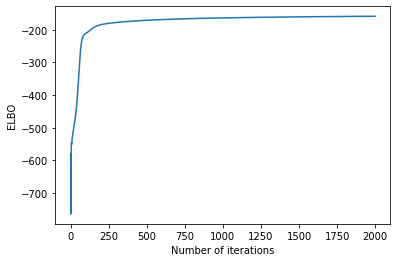

In [97]:
# For reproducibility
np.random.seed(123)
torch.manual_seed(123)

z_dim=2

vae = VAE(z_dim, encoder = Encoder(z_dim, hidden_dim=500), decoder = LinearDecoder(z_dim))
#vae = VAE(z_dim, encoder = Encoder(z_dim, hidden_dim=500), decoder = NonLinearDecoder(z_dim, hidden_dim=10))

# Run options
LEARNING_RATE = 0.01

# Number of learning epochs
NUM_EPOCHS = 2000

# clear param store
pyro.clear_param_store()

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
train_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, data.data)
    train_elbo.append(-total_epoch_loss_train)
    if (epoch % 100) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, total_epoch_loss_train))

plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()

# Plot the data in the latent space

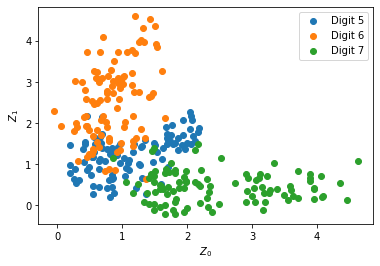

In [100]:
z_loc, z_scale = vae.encoder(data.data)

legends = ["Digit 5", "Digit 6", "Digit 7"]
z_loc = z_loc.detach().numpy()

for idx, i in enumerate([5,6,7]):
    plt.scatter(z_loc[data.targets.numpy()==i,0], z_loc[data.targets.numpy()==i,1], label=legends[idx])

plt.xlabel(r"$Z_0$")
plt.ylabel(r"$Z_1$")
plt.legend()
plt.show()

# **Exercise 2: Explore the latent space**

1. Look at the figure above where the latent space is plotted. 
2. Choose the coordinates of some part of the latent space (e.g. ($Z_0= 0,Z_1= 0$)). 
3. Sample images from this part of the latent space
4. Compare the quality of the samples when moving from a linear to a non-linear decoder. 
5. Explore what happens when we increase the capacity of the non-linear decoder (i.e we increase the number of hidden units). 

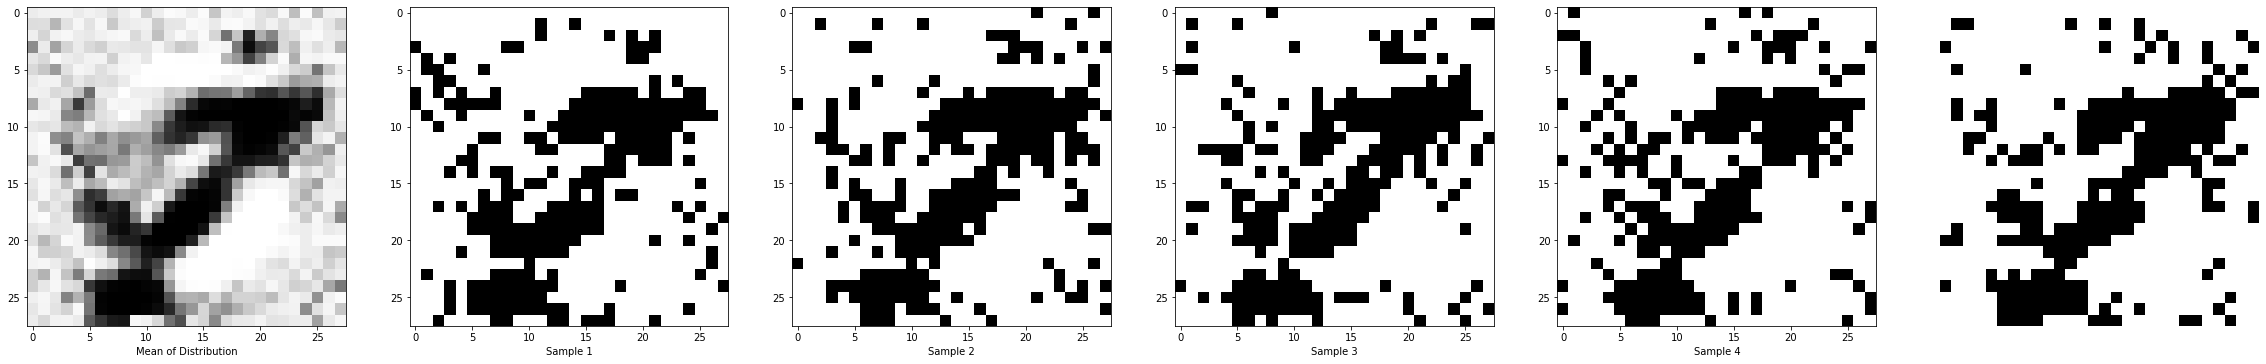

In [101]:
# Z = (Z_0, Z_1)
z=torch.tensor([[-2,0]], dtype=torch.float32)

# Pass Z through the decoder network
logits = vae.decoder.forward(z)

# Bernoulli distribution over images
distribution_over_images = dist.Bernoulli(logits=logits)


f, ax = plt.subplots(1, 6, figsize=(40, 40), sharex=True)
plt.axis('off')
ax[0].imshow(distribution_over_images.mean.detach().numpy().reshape((28, 28)), cmap="gray")
ax[0].set_xlabel('Mean of Distribution')
for i in range(1,6):
  ax[i].imshow(distribution_over_images.sample().detach().numpy().reshape((28, 28)), cmap="gray")
  ax[i].set_xlabel('Sample '+str(i))
plt.show()


